Normalization stats:
Mean: tensor([-5699.4873,  8023.7510])
Std: tensor([601.8121, 847.6780])
History range before norm: -5771.21 to 8124.70
History range after norm: -0.12 to 0.12


C:\Users\FarisHussain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([3, 1, 2])) that is different to the input size (torch.Size([3, 80, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch 50/200
epoch loss: 0.00022976209584157914
Average loss: 0.000230

Prediction Statistics:
Average prediction error: 24.58 meters
Final position error: 35.58 meters
Trajectory length - History: 11 steps, Future: 80 steps


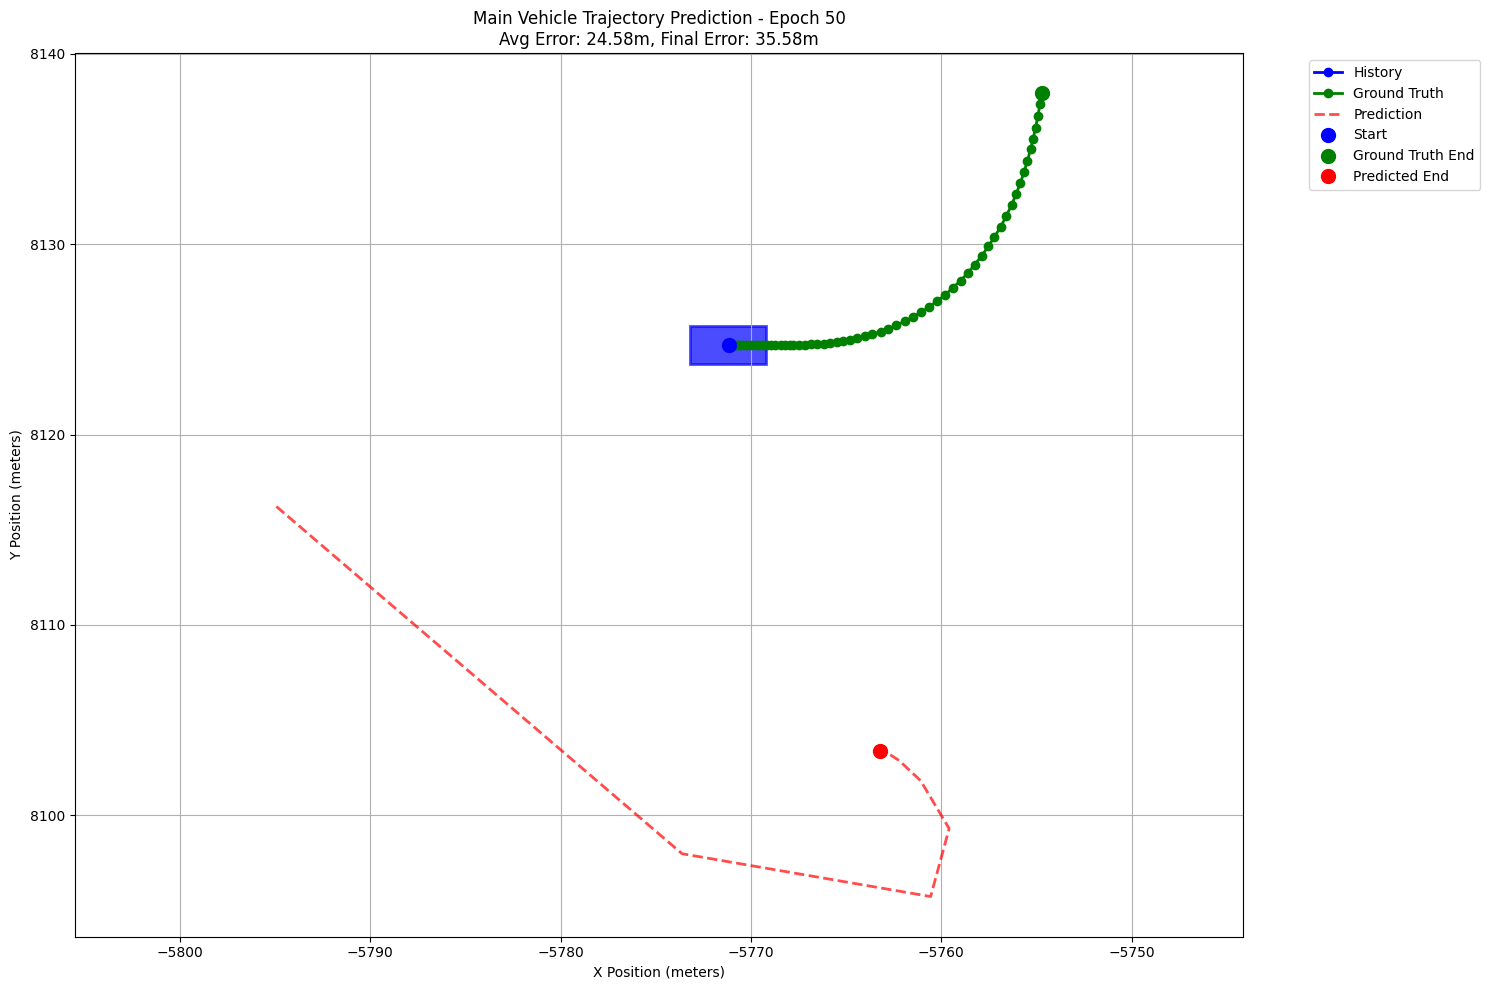

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from trajectory_dataset import TrajectoryDataset
from LSTM_NN_model import TrajectoryPredictorLSTM
   
class MainVehiclePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = TrajectoryPredictorLSTM()
    
    def forward(self, x):
        return self.base_model(x)
lr=0
epochs=0
def train_model(model, train_loader, epochs=epochs, lr=lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            # Only take the first vehicle from each batch as main vehicle
            hist = hist[:, 0:1].to(device)  # Take first vehicle
            fut = fut[:, 0:1].to(device)
            hist_valid = hist_valid[:, 0:1].to(device)
            fut_valid = fut_valid[:, 0:1].to(device)
            
            optimizer.zero_grad()
            pred = model(hist)
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Visualize every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"epoch loss: {epoch_loss}")
            print(f"Average loss: {avg_loss:.6f}")
            
            
            model.eval()
            with torch.no_grad():
                # Get a sample trajectory
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)
                
                # Visualize the prediction
                visualize_prediction(hist, fut, pred, epoch, train_loader.dataset)
    
    print("\nTraining completed!")
    print(f'losses={losses}')
    torch.save(model.state_dict(), 'trajectory_model.pth')

    # Plot final training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()

    return model, losses

def visualize_prediction(history, future, prediction, epoch, dataset):
    """
    Visualize the model's prediction with enhanced styling.
    Args:
        history: tensor of shape [1, 11, 2] - normalized historical trajectory
        future: tensor of shape [1, 80, 2] - normalized ground truth future trajectory
        prediction: tensor of shape [1, 80, 2] - normalized predicted future trajectory
        epoch: current training epoch
        dataset: dataset object for denormalization
    """
    # Denormalize all trajectories
    hist_denorm = dataset.denormalize(history.cpu())
    fut_denorm = dataset.denormalize(future.cpu())
    pred_denorm = dataset.denormalize(prediction.cpu())
    
    # Convert to numpy for plotting
    hist_denorm = hist_denorm.numpy()[0]  # [11, 2]
    fut_denorm = fut_denorm.numpy()[0]    # [80, 2]
    pred_denorm = pred_denorm.numpy()[0]   # [80, 2]
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot history trajectory
    plt.plot(hist_denorm[:, 0], hist_denorm[:, 1], 
            'o-', color='blue', alpha=1.0, linewidth=2,
            label='History')
    
    # Plot ground truth future trajectory
    plt.plot(fut_denorm[:, 0], fut_denorm[:, 1], 
            'o-', color='green', alpha=1.0, linewidth=2,
            label='Ground Truth')
    
    # Plot predicted future trajectory
    plt.plot(pred_denorm[:, 0], pred_denorm[:, 1], 
            '--', color='red', alpha=0.7, linewidth=2,
            label='Prediction')
    
    # Add vehicle rectangles at current position (last historical point)
    current_pos = hist_denorm[-1]
    # Assuming a standard vehicle size (you can adjust these)
    width, length = 2.0, 4.0

    # Vehicle rectangle at current position
    rect = Rectangle(
        (current_pos[0] - length/2, current_pos[1] - width/2),
        length, width,
        angle=0,  # We don't have yaw information here
        color='blue',
        alpha=0.7,
        linewidth=2
    )
    plt.gca().add_patch(rect)
    
    # Add markers for start and end points
    plt.plot(hist_denorm[0, 0], hist_denorm[0, 1], 'bo', markersize=10, label='Start')
    plt.plot(fut_denorm[-1, 0], fut_denorm[-1, 1], 'go', markersize=10, label='Ground Truth End')
    plt.plot(pred_denorm[-1, 0], pred_denorm[-1, 1], 'ro', markersize=10, label='Predicted End')
    
    # Calculate and display errors
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))
    
    plt.title(f'Main Vehicle Trajectory Prediction - Epoch {epoch + 1}\n'
             f'Avg Error: {error:.2f}m, Final Error: {final_error:.2f}m')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Print prediction statistics
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))

    print(f"\nPrediction Statistics:")
    print(f"Average prediction error: {error:.2f} meters")
    print(f"Final position error: {final_error:.2f} meters")
    print(f"Trajectory length - History: {len(hist_denorm)} steps, Future: {len(fut_denorm)} steps")
    
    plt.tight_layout()
    plt.show()
    
# The training function 

def main():
    # Load and prepare data
    dataset = TrajectoryDataset('..\processed_data\processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # Create and train model LSTM
    model = MainVehiclePredictor()
    model, losses = train_model(model, train_loader, epochs=200, lr=0.009)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from trajectory_dataset import TrajectoryDataset
from LSTM_NN_model import TrajectoryPredictorLSTM
from trajectory_dataset import TrajectoryDataset

def test_model(model_path, test_data_path):
   # Load the model
   model = TrajectoryPredictorLSTM()
   model.load_state_dict(torch.load(model_path))
   model.eval()
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model = model.to(device)
   
   # Load test data
   test_dataset = TrajectoryDataset(test_data_path)
   test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
   
   # Testing metrics
   total_error = 0
   predictions = []
   ground_truths = []
   
   with torch.no_grad():
       for i, ((hist, hist_valid), (fut, fut_valid)) in enumerate(test_loader):
           hist, fut = hist.to(device), fut.to(device)
           
           # Get prediction
           pred = model(hist)
           
           # Denormalize
           hist_denorm = test_dataset.denormalize(hist.cpu())
           fut_denorm = test_dataset.denormalize(fut.cpu())
           pred_denorm = test_dataset.denormalize(pred.cpu())
           
           # Visualize some examples
           if i % 10 == 0:  # Show every 10th prediction
               plt.figure(figsize=(10, 10))
               plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 'b-', label='History')
               plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 'g-', label='Ground Truth')
               plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 'r--', label='Prediction')
               plt.legend()
               plt.title(f'Test Sample {i}')
               plt.grid(True)
               plt.axis('equal')
               plt.show()
           
           # Calculate error
           error = ((pred_denorm - fut_denorm) ** 2).mean()
           total_error += error.item()
           
           predictions.append(pred_denorm)
           ground_truths.append(fut_denorm)
   
   avg_error = total_error / len(test_loader)
   print(f"Average test error: {avg_error:.6f}")
   
   return predictions, ground_truths, avg_error

# Example usage (update paths accordingly):
predictions, ground_truths, avg_error = test_model('trajectory_model.pth', 'processed_data_testing/processed_uncompressed_tf_example_testing_testing_tfexample.tfrecord-00001-of-00150.npz')

C:\Users\FarisHussain\AppData\Local\Temp\ipykernel_38704\2130943662.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for TrajectoryPredictorLSTM:
	Missing key(s) in state_dict: "encoder.weight_ih_l0", "encoder.weight_hh_l0", "encoder.bias_ih_l0", "encoder.bias_hh_l0", "encoder.weight_ih_l1", "encoder.weight_hh_l1", "encoder.bias_ih_l1", "encoder.bias_hh_l1", "decoder.weight_ih_l0", "decoder.weight_hh_l0", "decoder.bias_ih_l0", "decoder.bias_hh_l0", "decoder.weight_ih_l1", "decoder.weight_hh_l1", "decoder.bias_ih_l1", "decoder.bias_hh_l1", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "base_model.encoder.weight_ih_l0", "base_model.encoder.weight_hh_l0", "base_model.encoder.bias_ih_l0", "base_model.encoder.bias_hh_l0", "base_model.encoder.weight_ih_l1", "base_model.encoder.weight_hh_l1", "base_model.encoder.bias_ih_l1", "base_model.encoder.bias_hh_l1", "base_model.decoder.weight_ih_l0", "base_model.decoder.weight_hh_l0", "base_model.decoder.bias_ih_l0", "base_model.decoder.bias_hh_l0", "base_model.decoder.weight_ih_l1", "base_model.decoder.weight_hh_l1", "base_model.decoder.bias_ih_l1", "base_model.decoder.bias_hh_l1", "base_model.fc.weight", "base_model.fc.bias". 